# Playing with contours


In [1]:
import numpy as np
import imageio
%matplotlib inline
import matplotlib.pyplot as plt
from utils import * # tic toc imshow

import higra as hg

We will process a classical image from BSDS.

Image size: (321, 481)


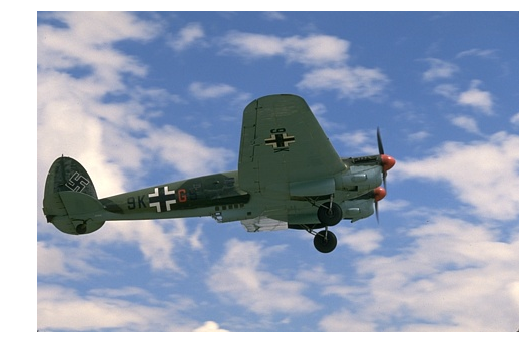

In [2]:
image = imageio.imread("data/3063.ppm")
# switch to float to avoir numerical issue with uint8
image = image.astype(np.float64)/255 
# discard the color channel
size = image.shape[:2]
print("Image size:", size)
imshow(image)

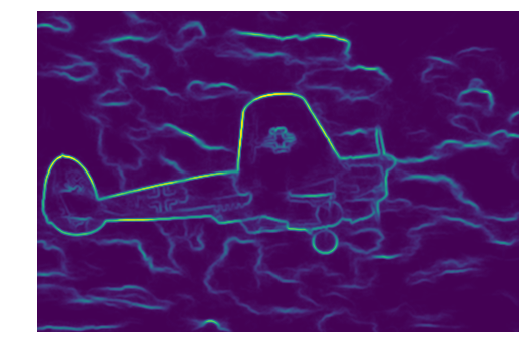

In [8]:
gradient_image = imageio.imread("data/3063_SED.png")
gradient_image = gradient_image.astype(np.float64)/255
imshow(gradient_image)

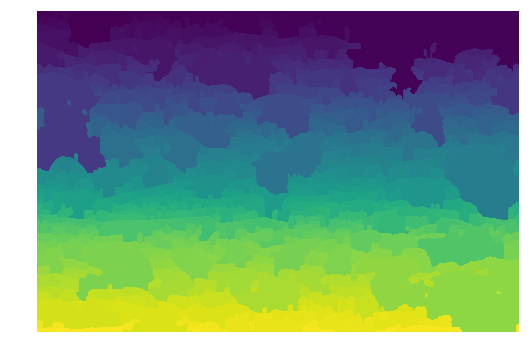

In [10]:

graph = hg.get_4_adjacency_graph(size)
edge_weights = hg.weight_graph(graph, gradient_image.flatten(), hg.WeightFunction.mean)
labelisation = hg.labelisation_watershed(graph)

imshow(labelisation.reshape(size))


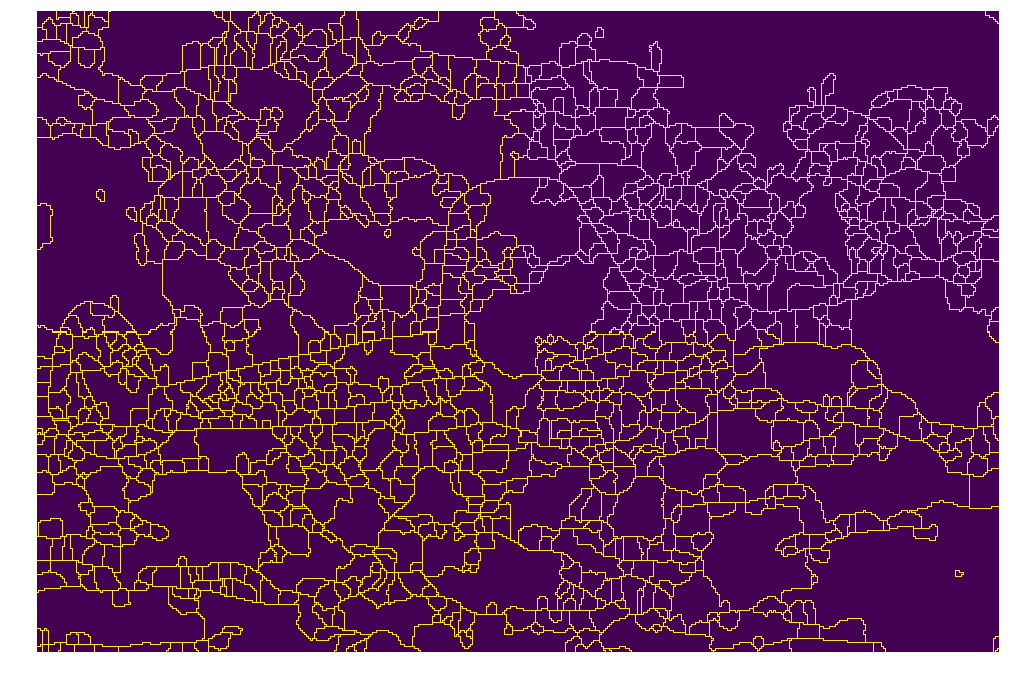

In [12]:
watershed_cut = hg.weight_graph(graph, labelisation, hg.WeightFunction.L0)
watershed_cut_khalimsky = hg.graph_4_adjacency_2_khalimsky(graph, size, watershed_cut)
imshow(watershed_cut_khalimsky)

In [44]:
from PIL import Image, ImageDraw
def drawContour(contour, size):
    image = np.zeros(size, np.uint8)+255
    image_pil = Image.fromarray(image)
    draw = ImageDraw.Draw(image_pil)

    for polyline in contour:
        for segment in polyline:
            p1 = segment[0][1]
            p2 = segment[len(segment) - 1][1]
            draw.line((p1[1],p1[0],p2[1],p2[0]), fill=0)
        
    del draw
    return  np.array(image_pil)
    

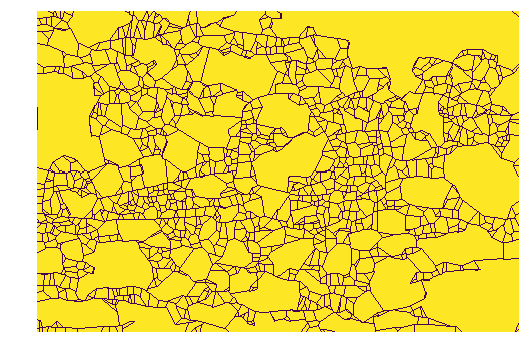

In [53]:
contours = hg.fit_contour_2d(graph, size, watershed_cut)
test = drawContour(contours, size)
imshow(test)

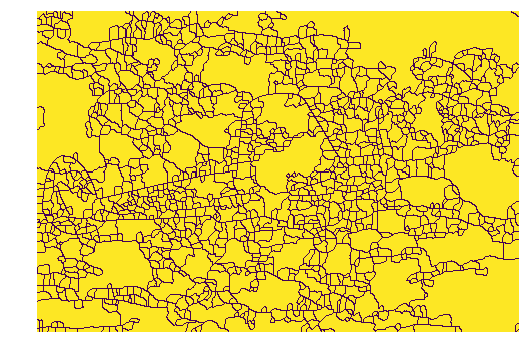

In [54]:
contours.subdivide(0, True, 0)
test = drawContour(contours, size)
imshow(test)